# Obesity Classification with PyTorch

## 1. Import all libraries required

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
import joblib
import optuna
from captum.attr import IntegratedGradients
import shap
import warnings
warnings.filterwarnings("ignore")

## 2. Read dataset, change target name and map the target

In [2]:
obesity = pd.read_csv("https://raw.githubusercontent.com/slathwal/obesity-estimation/refs/heads/main/data/raw/ObesityDataSet_raw_and_data_sinthetic.csv")

In [3]:
# change the target name from "NObeyesdad" to "target"
obesity.rename(columns={"NObeyesdad": "Target"}, inplace=True)

target_map = {
    "Insufficient_Weight": 0,
    "Normal_Weight": 1,
    "Obesity_Type_I": 2,
    "Obesity_Type_II": 3,
    "Obesity_Type_III": 4,
    "Overweight_Level_I": 5,
    "Overweight_Level_II": 6
    
}

obesity["Target"] = obesity["Target"].map(target_map)

## 3. Divide dataset into predictor and target

In [4]:
X = obesity.drop(columns=["Target"])
y = obesity["Target"]

## 4. Separate Categorical and Numerical features and do train test split

In [5]:
num_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## 5. Create preprocessing pipeline

In [6]:
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features)
    ]
)

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

feature_names = preprocessor.get_feature_names_out()
n_features = X_train_processed.shape[1]

# Convert target to integer labels
class_labels = np.unique(y)
n_classes = len(class_labels)

## 6. Create PyTorch dataloader

In [7]:
def create_dataloader(X, y, batch_size=32, shuffle=True):
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y.values if isinstance(y, pd.Series) else y, dtype=torch.long)
    dataset = TensorDataset(X_tensor, y_tensor)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

train_loader = create_dataloader(X_train_processed, y_train, batch_size=32)
test_loader = create_dataloader(X_test_processed, y_test, batch_size=32, shuffle=False)

## 7. Create neural network architecture

In [8]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, dropout_rate):
        super(MLP, self).__init__()
        layers = []
        prev_dim = input_dim
        for h in hidden_dims:
            layers.append(nn.Linear(prev_dim, h))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            prev_dim = h
        layers.append(nn.Linear(prev_dim, output_dim))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

## 8. Assign Optuna for hyperparameter tunning 

In [9]:
def objective(trial):
    hidden_dims = [trial.suggest_int("hidden1", 32, 128), trial.suggest_int("hidden2", 16, 64)]
    dropout_rate = trial.suggest_float("dropout", 0.1, 0.5)
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    
    model = MLP(n_features, hidden_dims, n_classes, dropout_rate)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Training loop
    model.train()
    for epoch in range(30):  # fixed epochs
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
    
    # Validation accuracy
    model.eval()
    y_pred = []
    y_true = []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            output = model(X_batch)
            y_pred.append(output.argmax(dim=1).numpy())
            y_true.append(y_batch.numpy())
    y_pred = np.concatenate(y_pred)
    y_true = np.concatenate(y_true)
    acc = accuracy_score(y_true, y_pred)
    return acc

## 9. Optuna study for hyperparameter tunning

In [10]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

print("Best hyperparameters:", study.best_params)

[I 2025-11-14 02:58:10,356] A new study created in memory with name: no-name-ad19e340-faff-46f5-bb91-6f85db7d1eb8
[I 2025-11-14 02:58:14,839] Trial 0 finished with value: 0.9385342789598109 and parameters: {'hidden1': 128, 'hidden2': 21, 'dropout': 0.16334947492611857, 'lr': 0.0003829799147255123}. Best is trial 0 with value: 0.9385342789598109.
[I 2025-11-14 02:58:17,134] Trial 1 finished with value: 0.9267139479905437 and parameters: {'hidden1': 71, 'hidden2': 51, 'dropout': 0.31956042443247484, 'lr': 0.009209076818969418}. Best is trial 0 with value: 0.9385342789598109.
[I 2025-11-14 02:58:19,421] Trial 2 finished with value: 0.9243498817966903 and parameters: {'hidden1': 66, 'hidden2': 51, 'dropout': 0.3913362540770279, 'lr': 0.00907599314846264}. Best is trial 0 with value: 0.9385342789598109.
[I 2025-11-14 02:58:21,763] Trial 3 finished with value: 0.8557919621749409 and parameters: {'hidden1': 106, 'hidden2': 37, 'dropout': 0.2828785768020693, 'lr': 0.00020973550764382258}. Best

Best hyperparameters: {'hidden1': 37, 'hidden2': 64, 'dropout': 0.17203297117383037, 'lr': 0.0017956050722297146}


## 10. Train model with the best hyperparameters

In [11]:
best_params = study.best_params
hidden_dims = [best_params["hidden1"], best_params["hidden2"]]
dropout_rate = best_params["dropout"]
lr = best_params["lr"]

final_model = MLP(n_features, hidden_dims, n_classes, dropout_rate)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(final_model.parameters(), lr=lr)

# Training loop
final_model.train()
for epoch in range(50):
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = final_model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()

## 11. Save the best model

In [12]:
torch.save(final_model.state_dict(), "best_model.pth")
joblib.dump(preprocessor, "preprocessor.pkl")

['preprocessor.pkl']

## 12. Calculate the metrics

In [13]:
final_model.eval()
X_train_tensor = torch.tensor(X_train_processed, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_processed, dtype=torch.float32)

y_train_pred = final_model(X_train_tensor).argmax(dim=1).numpy()
y_test_pred = final_model(X_test_tensor).argmax(dim=1).numpy()

print("Train Accuracy:", accuracy_score(y_train, y_train_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("Precision (macro):", precision_score(y_test, y_test_pred, average="macro"))
print("Recall (macro):", recall_score(y_test, y_test_pred, average="macro"))
print("F1-score (macro):", f1_score(y_test, y_test_pred, average="macro"))

Train Accuracy: 0.9917061611374408
Test Accuracy: 0.9527186761229315
Precision (macro): 0.9513387524981481
Recall (macro): 0.9515085079124488
F1-score (macro): 0.9509114136732221


## 13. Calculate the classification report and the confusion matrix

In [14]:
from sklearn.metrics import classification_report
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97        54
           1       0.91      0.83      0.86        58
           2       0.99      0.99      0.99        70
           3       0.98      0.98      0.98        60
           4       1.00      0.98      0.99        65
           5       0.85      0.91      0.88        58
           6       0.98      0.97      0.97        58

    accuracy                           0.95       423
   macro avg       0.95      0.95      0.95       423
weighted avg       0.95      0.95      0.95       423



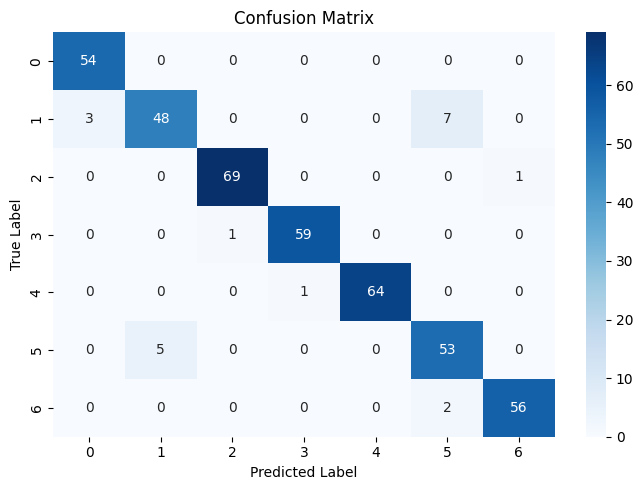

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.savefig(f"images/PyTorch_Confusion matrix.png", dpi=400)
plt.show()

## 14. Plot ROC AUC curve

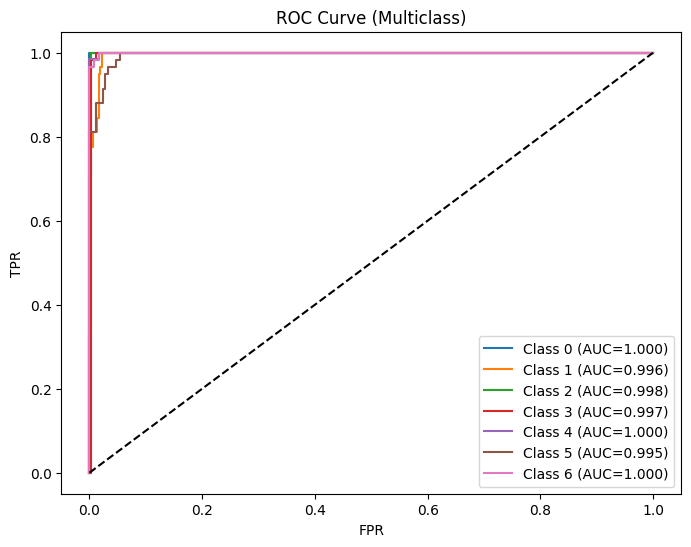

In [16]:
y_test_bin = label_binarize(y_test, classes=class_labels)
y_test_tensor = torch.tensor(y_test_bin, dtype=torch.float32)
probs = final_model(X_test_tensor)
probs_np = torch.softmax(probs, dim=1).detach().numpy()

plt.figure(figsize=(8,6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], probs_np[:, i])
    auc = roc_auc_score(y_test_bin[:, i], probs_np[:, i])
    plt.plot(fpr, tpr, label=f"Class {i} (AUC={auc:.3f})")
plt.plot([0,1],[0,1],"k--")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve (Multiclass)")
plt.legend()
plt.savefig(f"images/PyTorch_ROC_curve.png", dpi=400)
plt.show()

## 15. Calculate and plot the feature importance for each classes

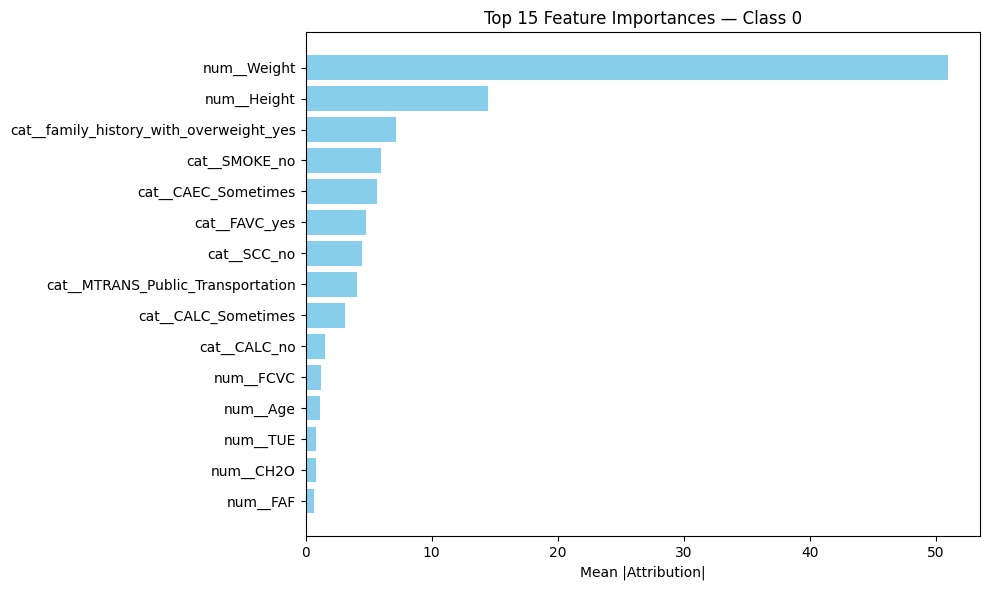

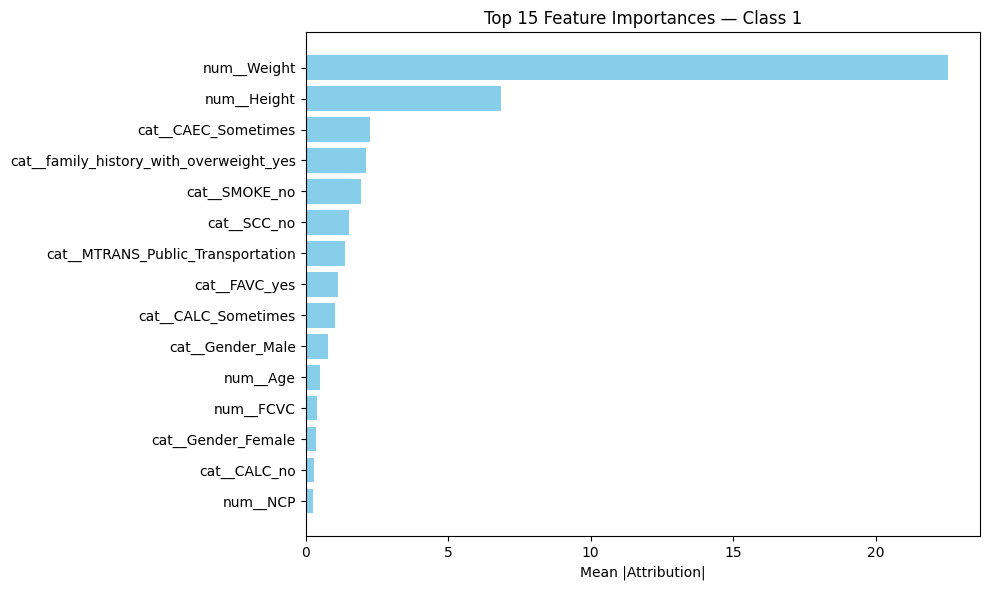

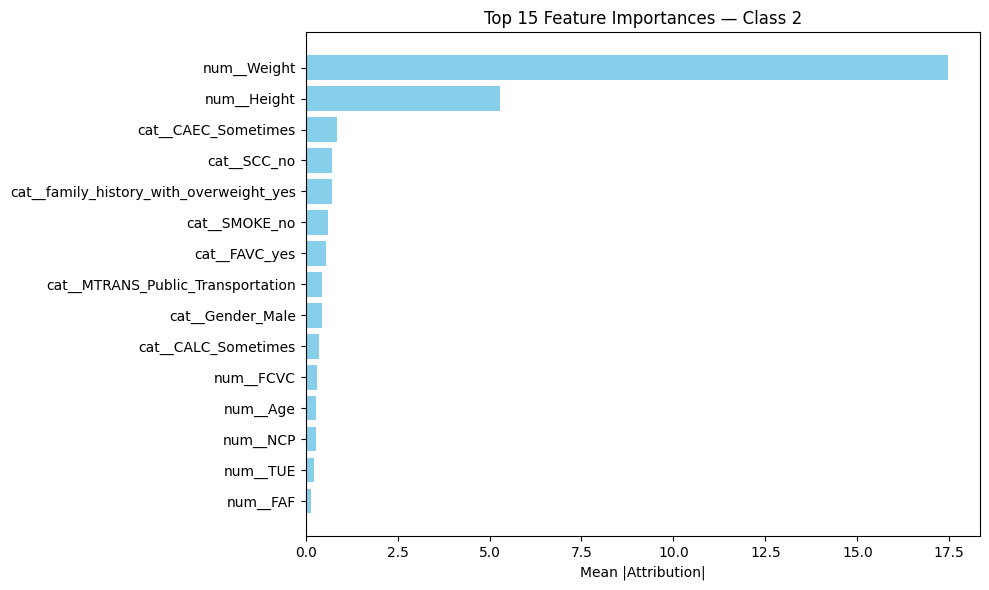

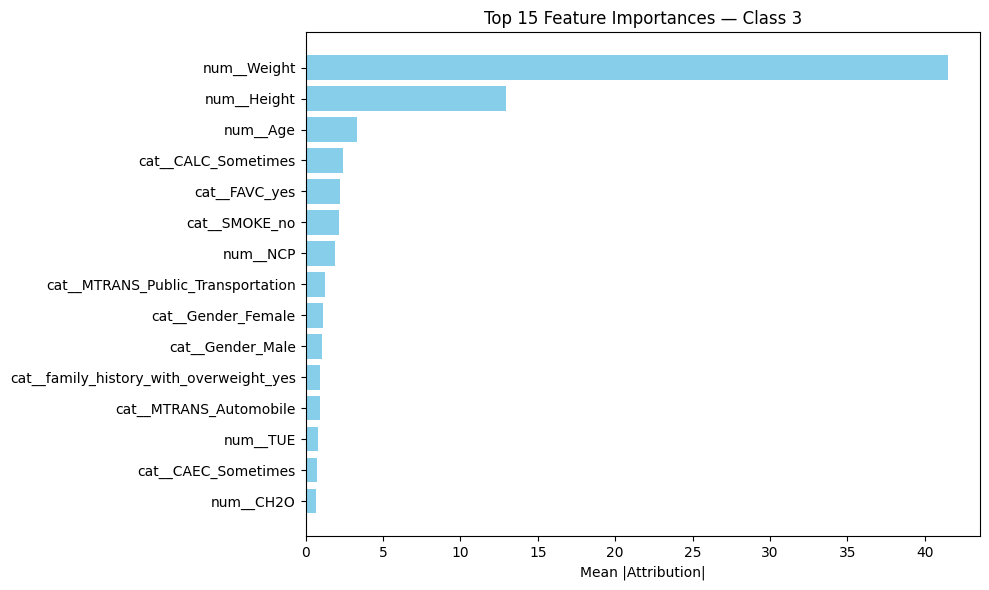

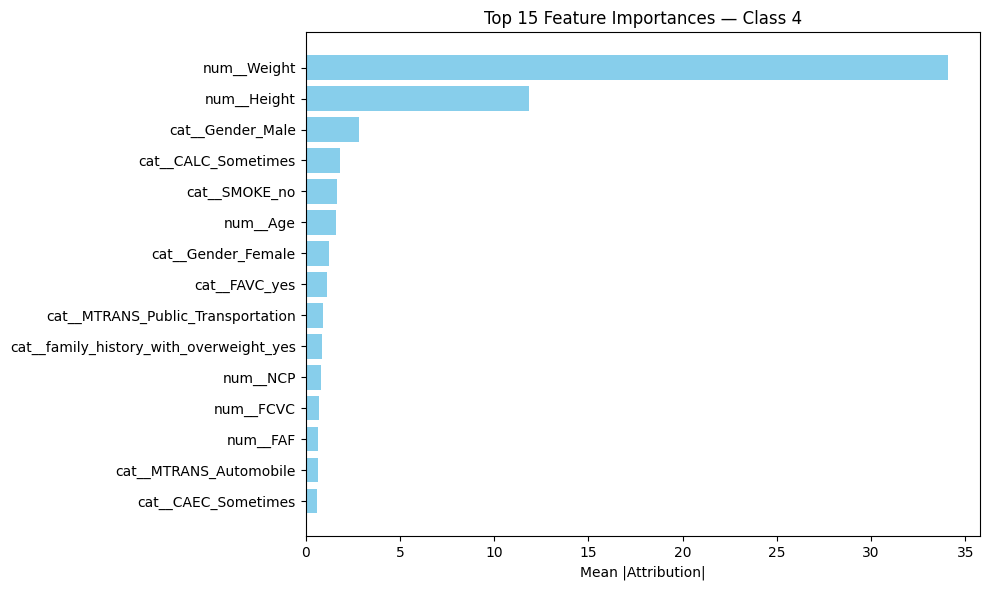

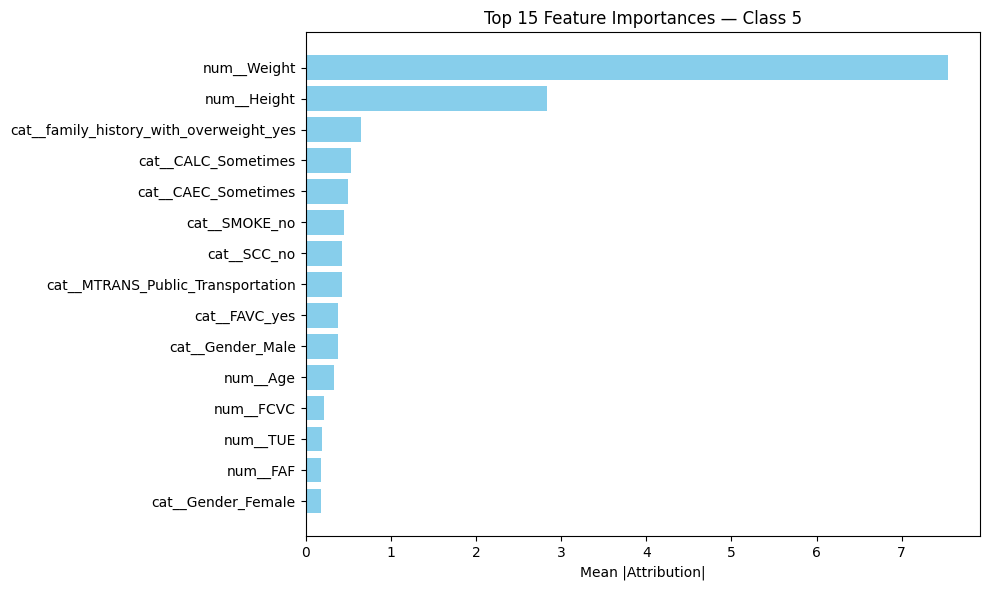

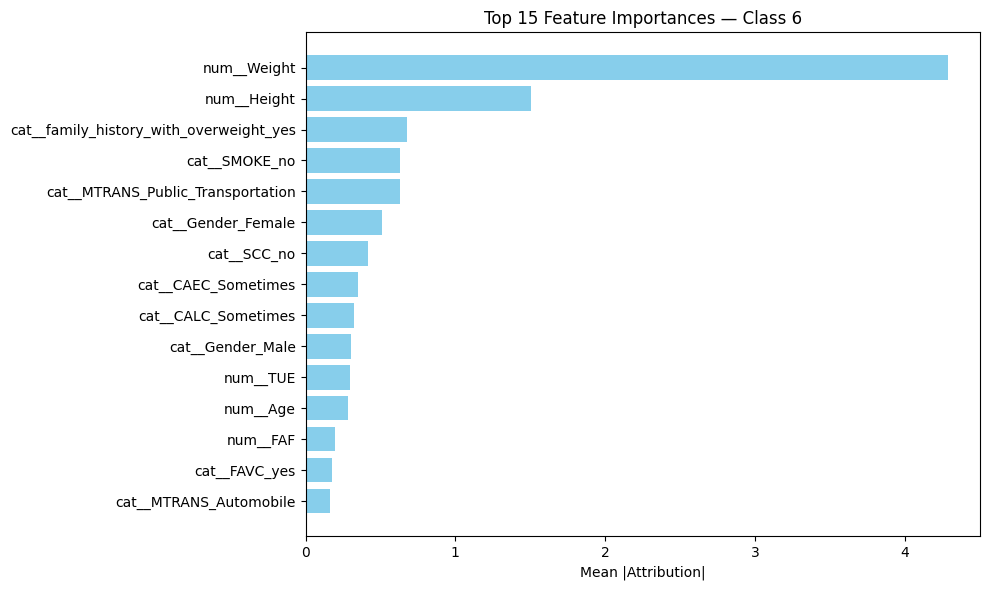

In [17]:
os.makedirs("feature_importance_plots", exist_ok=True)
ig = IntegratedGradients(final_model)

X_test_tensor = torch.tensor(X_test_processed, dtype=torch.float32)

for class_idx in range(n_classes):
    attributions, delta = ig.attribute(X_test_tensor, target=class_idx, return_convergence_delta=True)
    attributions = attributions.detach().numpy()
    mean_attr = np.mean(np.abs(attributions), axis=0)
    top_idx = np.argsort(mean_attr)[::-1][:15]
    top_features = feature_names[top_idx]
    top_values = mean_attr[top_idx]
    
    plt.figure(figsize=(10,6))
    plt.barh(top_features[::-1], top_values[::-1], color="skyblue")
    plt.xlabel("Mean |Attribution|")
    plt.title(f"Top 15 Feature Importances — Class {class_idx}")
    plt.tight_layout()
    plt.savefig(f"images/PyTorch_top15_class{class_idx}.png", dpi=400)
    plt.show()